In [1]:
import torch
import numpy
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import imageio 
import io
import pandas as pd

In [2]:
#state_0, position, min = -1.2, max = 0.6
#state_1, velocity, min = -0.07, max = 0.07
#action: -1 is left, 0 is do nothing, 1 is right
#Default Reward: -1 each time step
#Override reward: (0.5 - position) #0.5 is the goal position

In [3]:
#state = position, velocity
def get_mountain_car_data(force=0.001,gravity=0.0025):
    #no actions
    data = []
    position_linspace = np.arange(-1.2, 0.6, 0.01)
    velocity_linspace = np.arange(-0.07, 0.07, 0.01)
    #actions = [0,1,2] #left, none, right
    for position in position_linspace:
        for velocity in velocity_linspace:
        #for action in actions:
            #action is random float between -1 and 1 
            action = random.uniform(-1, 1)
            state = torch.tensor([position, velocity],dtype=torch.float32)
            next_velocity =  velocity + force*(action) - gravity*np.cos(3*position)
            next_position = position + next_velocity
            next_state = torch.tensor([next_position, next_velocity],dtype=torch.float32)
            a = torch.tensor([action],dtype=torch.float32)
            reward = -(position - 0.5)**2
            reward = torch.tensor(reward,dtype=torch.float32)
            data.append((state, a, reward, next_state))
    return data

In [4]:
class LQR(nn.Module):
    def __init__(self, enc_dim,state_in_dim, action_in_dim):
        super(LQR, self).__init__()
        self.A = torch.nn.Parameter(torch.randn(enc_dim, enc_dim))
        self.B = torch.nn.Parameter(torch.randn(enc_dim, enc_dim))
        self.Q = torch.nn.Parameter(torch.randn(enc_dim, enc_dim))
        self.R = torch.nn.Parameter(torch.randn(enc_dim, enc_dim))

        self.state_encoder = torch.nn.Sequential(
            torch.nn.Linear(state_in_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, enc_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim, enc_dim),
        )

        self.state_decoder = torch.nn.Sequential(
            torch.nn.Linear(enc_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, state_in_dim)
        )

        self.action_encoder = torch.nn.Sequential(
            torch.nn.Linear(action_in_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, enc_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim, enc_dim),
        )

        self.action_decoder = torch.nn.Sequential(
            torch.nn.Linear(enc_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, action_in_dim)
        )

    def forward (self,x,u):
        xx = self.state_encoder(x)
        uu = self.action_encoder(u) 

        x_prime_prediction = self.A @ xx + self.B @ uu
        Q_PSD = (self.Q @ self.Q.t()) + 0.01
        R_PSD = (self.R @ self.R.t()) + 0.01
        predicted_reward = -(xx.t() @ Q_PSD @ xx + uu.t() @ R_PSD @ uu)

        decode_action = self.action_decoder(uu)
        return self.state_decoder(x_prime_prediction), x_prime_prediction, xx, decode_action, predicted_reward

In [5]:
def train_model(model,optimizer,train_data_loader,test_data,epochs=1):
    criterion = torch.nn.MSELoss()
    for i in range(epochs):
        total_state_loss = 0
        total_action_loss = 0
        total_reward_loss = 0
        for x, u, r, y in train_data_loader:
            x = x.squeeze(0)
            y = y.squeeze(0)
            u = u.squeeze(0)
            r = r.squeeze(0)
            optimizer.zero_grad()
            lqr_x_prime, x_prime_expanded, xx, lqr_u_decode, lqr_reward_pred = model(x,u)
            lqr_pred_loss = criterion(lqr_x_prime, y)
            decoder_loss = criterion(model.state_decoder(xx), x)
            encoder_loss = criterion(model.state_encoder(y), x_prime_expanded) 
            action_loss = criterion(lqr_u_decode, u)
            total_action_loss += action_loss.item()
            state_loss = lqr_pred_loss  + decoder_loss + encoder_loss
            reward_loss = criterion(lqr_reward_pred, r)
            total_reward_loss += reward_loss.item()
            loss = state_loss + action_loss + reward_loss
            loss.backward()
            optimizer.step()
            total_state_loss += state_loss.item()
        test_state_loss = 0 
        test_action_loss = 0
        test_reward_loss = 0
        for x,u,r,y in test_data:
            with torch.no_grad():
                x = x.squeeze(0)
                y = y.squeeze(0)
                lqr_x_prime, x_prime_expanded, xx, lqr_u_decode, lqr_reward_pred = model(x,u)
                lqr_pred_loss = criterion(lqr_x_prime, y)
                decoder_loss = criterion(model.state_decoder(xx), x)
                encoder_loss = criterion(model.state_encoder(y), x_prime_expanded) 
                action_loss = criterion(lqr_u_decode, u)
                test_action_loss += action_loss.item()
                state_loss = lqr_pred_loss  + decoder_loss + encoder_loss
                test_state_loss += state_loss.item()
                reward_loss = criterion(lqr_reward_pred, r)
                test_reward_loss += reward_loss.item()
        print(f"Epoch {i} Train State Loss: {total_state_loss/len(train_data_loader)} Action Loss: {total_action_loss/len(train_data_loader)} Reward Loss: {total_reward_loss/len(train_data_loader)} Test State Loss: {test_state_loss/len(test_data)} Test Action Loss: {test_action_loss/len(test_data)} Test Reward Loss: {test_reward_loss/len(test_data)}")

In [6]:
all_data = get_mountain_car_data()
random.shuffle(all_data)
train_data = all_data[:int(len(all_data)*0.8)]
test_data = all_data[int(len(all_data)*0.8):]
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
print(f"Train Data Length: {len(train_data)}")
print(f"Test Data Length: {len(test_data)}")


Train Data Length: 2160
Test Data Length: 540


In [7]:
model = LQR(32,2,1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
train_model(model,optimizer,train_data_loader,test_data,epochs=30)

Epoch 0 Train State Loss: 0.10139206260533279 Action Loss: 0.07022694134659867 Reward Loss: 1.654526350505095 Test State Loss: 0.00943567145107038 Test Action Loss: 0.00025208331308776687 Test Reward Loss: 0.0059373541871328185
Epoch 1 Train State Loss: 0.009701288075302728 Action Loss: 0.00011200279724072327 Reward Loss: 0.003166872941275241 Test State Loss: 0.006029032829165872 Test Action Loss: 4.163334252484529e-05 Test Reward Loss: 0.0015070319377838504
Epoch 2 Train State Loss: 0.006836246537272085 Action Loss: 0.00011935802215013755 Reward Loss: 0.003293799277049579 Test State Loss: 0.004485604057467922 Test Action Loss: 4.374146340400696e-05 Test Reward Loss: 0.0018553509092591343
Epoch 3 Train State Loss: 0.009224149265463456 Action Loss: 0.001973597601018682 Reward Loss: 0.058019319255105846 Test State Loss: 0.003851733263474199 Test Action Loss: 0.0002837896493204227 Test Reward Loss: 0.0012440221048846106
Epoch 4 Train State Loss: 0.003915914005470027 Action Loss: 0.0001641

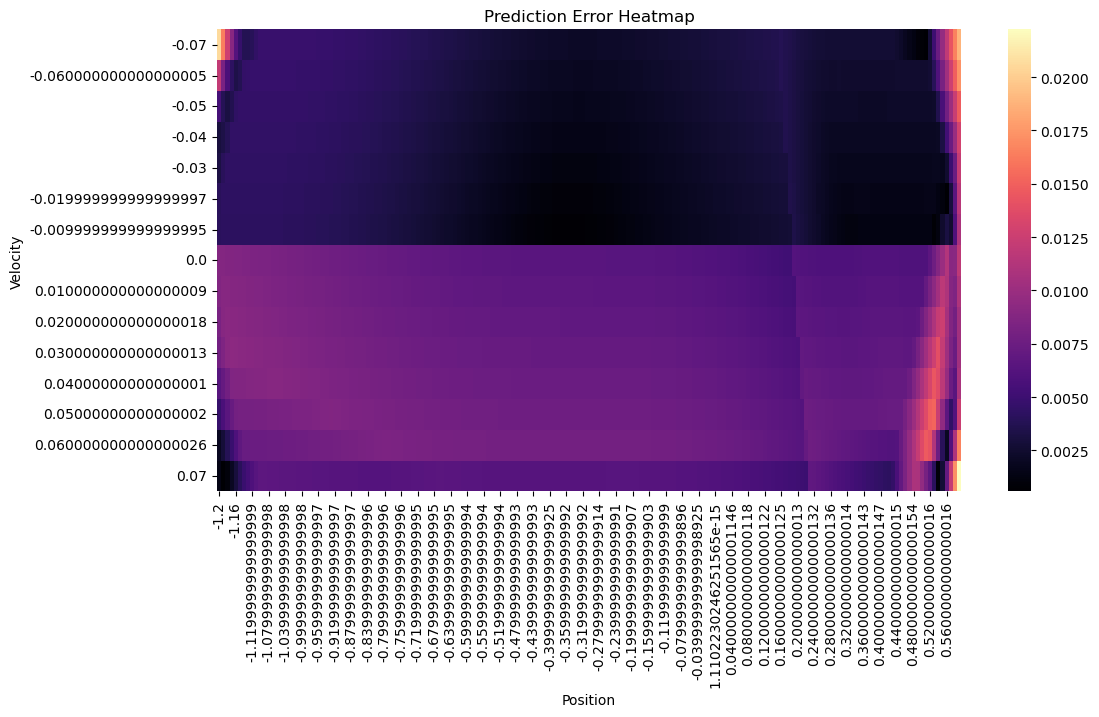

In [9]:
true_ns_pred_ns = []

for position in np.arange(-1.2, 0.6, 0.01):
    for velocity in np.arange(-0.07, 0.07, 0.01):
        optimal_action = -1 if velocity < 0 else 1
        state = torch.tensor([position, velocity], dtype=torch.float32)
        action = torch.tensor([optimal_action], dtype=torch.float32)
        true_next_state = state + torch.tensor(
            [velocity + 0.001 * (optimal_action) - 0.0025 * np.cos(3 * position), 0], dtype=torch.float32
        )
        with torch.no_grad():
            next_state_pred, _, _, _, _ = model(state, action)

        error = np.linalg.norm([
            true_next_state[0].item() - next_state_pred[0].item(),
            true_next_state[1].item() - next_state_pred[1].item()
        ])

        true_ns_pred_ns.append((position, velocity, error))

# Convert to DataFrame
df = pd.DataFrame(true_ns_pred_ns, columns=["position", "velocity", "error"])

# Pivot for heatmap
heatmap_data = df.pivot(index="velocity", columns="position", values="error")

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="magma", cbar=True)
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.title("Prediction Error Heatmap")
plt.show()


In [10]:
#sample random state
random_position = random.uniform(-1.2, 0.6)
random_velocity = random.uniform(-0.07, 0.07)

In [11]:

for action in [-1,0,1]:
    with torch.no_grad():
        state = torch.tensor([random_position, random_velocity],dtype=torch.float32)
        action = torch.tensor([action],dtype=torch.float32)
        true_next_state = torch.tensor([random_position + random_velocity, random_velocity + 0.001*(action) - 0.0025*np.cos(3*random_position)],dtype=torch.float32)
        lqr_x_prime, x_prime_expanded, xx, lqr_u_decode, lqr_reward_pred = model(state,action)
        print(f"Action Taken: {action}")
        print(f"True Next State: {true_next_state}")
        print(f"Predicted Next State: {lqr_x_prime}")
        print(f"Loss: {torch.nn.MSELoss()(lqr_x_prime, true_next_state)}")

Action Taken: tensor([-1.])
True Next State: tensor([-0.7920, -0.0692])
Predicted Next State: tensor([-0.7954, -0.0697])
Loss: 5.970012807665626e-06
Action Taken: tensor([0.])
True Next State: tensor([-0.7920, -0.0682])
Predicted Next State: tensor([-0.7955, -0.0686])
Loss: 6.260844202188309e-06
Action Taken: tensor([1.])
True Next State: tensor([-0.7920, -0.0672])
Predicted Next State: tensor([-0.7897, -0.0639])
Loss: 8.025957868085243e-06


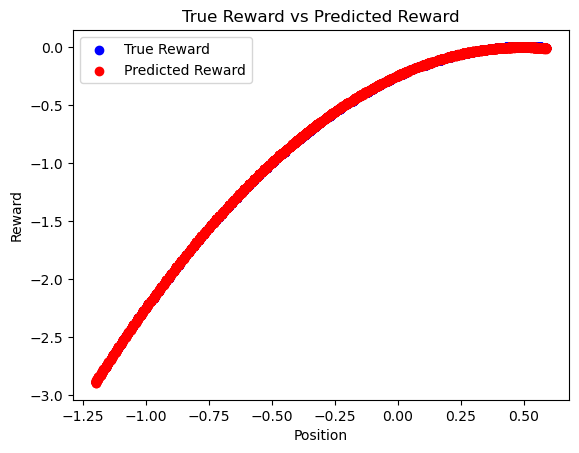

In [12]:
true_reward_pred_reward = []
for x,u,r,y in train_data:
    with torch.no_grad():
        x = x.squeeze(0)
        y = y.squeeze(0)
        lqr_x_prime, x_prime_expanded, xx, lqr_u_decode, lqr_reward_pred = model(x,u)
        true_reward_pred_reward.append((x[0].item(),r.item(),lqr_reward_pred.item()))
true_reward_pred_reward = np.array(true_reward_pred_reward)
#make true blue, pred red
plt.scatter(true_reward_pred_reward[:,0],true_reward_pred_reward[:,1],color='blue')
plt.scatter(true_reward_pred_reward[:,0],true_reward_pred_reward[:,2],color='red')
plt.xlabel("Position")
plt.ylabel("Reward")
plt.legend(["True Reward","Predicted Reward"])
plt.title("True Reward vs Predicted Reward")
plt.show()

## Getting K

In [13]:
#state = position, velocity
def get_mountain_car_data_optimal_policy(force=0.001,gravity=0.0025):
    #no actions
    data = []
    position_linspace = np.arange(-1.2, 0.6, 0.01)
    velocity_linspace = np.arange(-0.07, 0.07, 0.01)
    for position in position_linspace:
        for velocity in velocity_linspace:
            #action should be optimal action
            if velocity < 0:
                action = -1
            else:
                action = 1
            state = torch.tensor([position, velocity],dtype=torch.float32)
            #nv = v + .001*(actions - 1) - .0025*np.cos(3*x) #changed action to 0
            next_velocity =  velocity + force*(action) - gravity*np.cos(3*position)
            next_position = position + next_velocity
            next_state = torch.tensor([next_position, next_velocity],dtype=torch.float32)
            a = torch.tensor([action],dtype=torch.float32)
            #reward = torch.tensor((0 - next_position),dtype=torch.float32)
            reward = -(position - 0.5)**2
            reward = torch.tensor(reward,dtype=torch.float32)
            data.append((state, a, reward, next_state,velocity))
    return data

In [ ]:
trained_A = model.A.detach().numpy()
trained_B = model.B.detach().numpy()
trained_Q = model.Q.detach().numpy()
trained_R = model.R.detach().numpy()
trained_Q_PSD = (trained_Q @ trained_Q.T) +0.1
trained_R_PSD = (trained_R @ trained_R.T) +0.1

P = solve_continuous_are(trained_A,trained_B,trained_Q_PSD,trained_R_PSD)
K = np.linalg.inv(trained_R_PSD) @ trained_B.T @ P

In [16]:
print("Trained A Max", np.max(trained_A), "Min", np.min(trained_A), "Mean", np.mean(trained_A))
print("Trained B Max", np.max(trained_B), "Min", np.min(trained_B), "Mean", np.mean(trained_B))
print("Trained Q_PSD Max", np.max(trained_Q_PSD), "Min", np.min(trained_Q_PSD), "Mean", np.mean(trained_Q_PSD))
print("Trained R_PSD Max", np.max(trained_R_PSD), "Min", np.min(trained_R_PSD), "Mean", np.mean(trained_R_PSD))
print("P Max", np.max(P), "Min", np.min(P), "Mean", np.mean(P))
print("K Max", np.max(K), "Min", np.min(K), "Mean", np.mean(K))


Trained A Max 3.32163 Min -2.9960618 Mean -0.038080372
Trained B Max 2.9917846 Min -3.2703784 Mean 0.001204893
Trained Q_PSD Max 51.542255 Min -15.601771 Mean 0.8440199
Trained R_PSD Max 31.903124 Min -10.646046 Mean 0.91391736
P Max 21.78865425881559 Min -11.205342534579751 Mean 0.19241157517802343
K Max 188.9082873109525 Min -198.16501506275637 Mean -0.006066077138133591


In [17]:
#check if Q_PSD = Q_PSD.T
print(np.allclose(trained_Q_PSD,trained_Q_PSD.T))
print(np.allclose(trained_R_PSD,trained_R_PSD.T))

True
True


In [18]:
#check if Q_PSD is positive definite
print(np.linalg.eigvals(trained_Q_PSD)>0)
print(np.linalg.eigvals(trained_R_PSD)>0)
#print(np.linalg.eigvals(trained_R_PSD))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


In [26]:
pred_action_vs_true = []
optimal_policy_data = get_mountain_car_data_optimal_policy()
##Need policy data
for i in optimal_policy_data:
    x,u,r,y,v = i
    with torch.no_grad():
        x = x.squeeze(0)
        y = y.squeeze(0)
        lqr_x_prime, x_prime_expanded, xx, lqr_u_decode, lqr_reward_pred = model(x,u)
        pred_action = -K @ xx.numpy()

        pred_action = model.action_decoder(torch.tensor(pred_action,dtype=torch.float32)).numpy()
        if pred_action.item() > 0:
            pred_action = 1
        else:
            pred_action = -1
        pred_action_vs_true.append([v,u.item(), pred_action])

In [27]:
pred_action_vs_true[0]

[-0.07, -1.0, 1]

In [28]:
data = pd.DataFrame(pred_action_vs_true,columns=["Velocity","True Action","Predicted Action"])
data["Correct"] = data["True Action"] == data["Predicted Action"]
data["Correct"].sum()/len(data)

0.5292592592592592

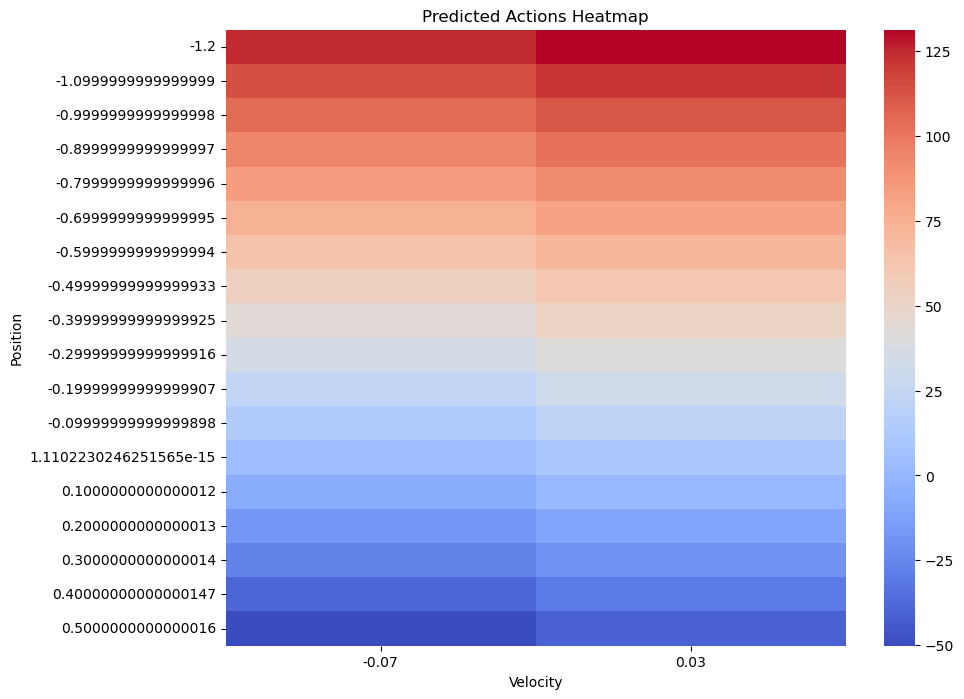

,position,velocity,action
count,36.000000,36.000000,36.000000
mean,-0.350000,-0.020000,42.286044
std,0.526172,0.050709,53.554927
min,-1.200000,-0.070000,-50.187012
25%,-0.800000,-0.070000,-0.827210
50%,-0.350000,-0.020000,42.766291
75%,0.100000,0.030000,86.040058
max,0.500000,0.030000,131.366730


In [29]:
true_velocities = np.arange(-0.07,0.07,0.1)
true_positions = np.arange(-1.2,0.6,0.1)
output_actions = []
for p in true_positions: 
    for v in true_velocities:
        x = torch.tensor([p,v],dtype=torch.float32)
        xx = model.state_encoder(x)
        pred_action = -K @ xx.detach().numpy()
        pred_action = model.action_decoder(torch.tensor(pred_action,dtype=torch.float32).detach()).detach().numpy()
        # if pred_action.item() > 1:
        #     pred_action = 2
        # else:
        #     pred_action = 0
        pred_action = pred_action.item()
        #print(pred_action)
        output_actions.append([p,v,pred_action])
# Given values
true_velocities = np.arange(-0.07, 0.07, 0.1)
true_positions = np.arange(-1.2, 0.6, 0.1)

# Create a DataFrame
df = pd.DataFrame(output_actions, columns=["position", "velocity", "action"])

# Pivot the data for heatmap (rows: positions, columns: velocities)
heatmap_data = df.pivot(index="position", columns="velocity", values="action")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=False, cbar=True)
plt.title("Predicted Actions Heatmap")
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.show()

df.describe()
